In [1]:
import numpy as np
import pandas as pd
import cv2
from keras.models import load_model
from joblib import load 
from collections import namedtuple
import matplotlib.pyplot as plt

In [2]:
model = load_model('character_recog_model.hdf5')
LB = load('Label_Binarizer.joblib')

In [3]:
l = [97,98,100,101,102,103,104,110,113,114,116]
values = [chr(i) for i in range (48,58)] +  [chr(i) for i in range (65,91)] + [chr(i) for i in l]

In [4]:
def dataExtractor(img):
    x,y,_ = img.shape
    if x<1700 and y<2200:
        form = cv2.resize(img,(1700,2200),interpolation = cv2.INTER_CUBIC)
    elif x>1700 and y>2200:
        form = cv2.resize(img,(1700,2200),interpolation = cv2.INTER_AREA)
    else:
        form =img
    return section_divide(form)
    

In [5]:
def section_divide(form):
    
    OCRLocation = namedtuple("OCRLocation",["id","bbox","no_boxes"])
    
    OCR_LOCATIONS = [
        OCRLocation("First Name: ",(260,325,1665,395),30),
        OCRLocation("Middle Name: ",(305,425,1665,495),29),
        OCRLocation("Last Name: ",(260,525,1665,595),30),
        OCRLocation("Gender: ",(340,630,405,690),1),
        OCRLocation("Blood Group: ",(980,630,1145,690),3),
        OCRLocation("Date of Birth: ",(475,725,970,790),10),
        OCRLocation("Contact No: ",(265,825,745,890),10),
        OCRLocation("Email: ",(165,930,1665,990),32)
    ]
    OCRform = pd.DataFrame(columns=['Id','Value'])
    
    for loc in OCR_LOCATIONS:
        (x1,y1,x2,y2) = loc.bbox
        section = form[y1:y2,x1:x2]
        value = field_OCR(section,loc.no_boxes)
        dic = {'Id': loc.id, 'Value': value}
        OCRform = OCRform.append(dic,ignore_index=True)
    return OCRform

In [6]:
def field_OCR(section,nb):
    gray = cv2.cvtColor(section.copy(),cv2.COLOR_BGR2GRAY)
    dilated = cv2.dilate(gray.copy(),(7,7),iterations=1)
    _,binary = cv2.threshold(gray.copy(),127,255,cv2.THRESH_BINARY_INV)
    cnts= cv2.findContours(binary, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0]
    x,y,w,h = cv2.boundingRect(cnts[0])
    box = binary[y:y+h,x:x+w]
    pwb = round(w/nb)
    letters = []
    blank_counts = 0 
    for i in range(nb):
        char = box[0:h,(i*pwb):((i+1)*pwb)]
        value = char_recog(char,nb)
        if value == "":
            blank_counts +=1
        if blank_counts == 2:
            break
        letters.append(value)
    return "".join(letters)

In [7]:
def char_recog(char,nb):    
    dilated = cv2.dilate(char.copy(), None, iterations=1)
    conts = cv2.findContours(dilated.copy(), cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[0]
    cnts=[]
    for cnt in conts:
        x,y,w,h = cv2.boundingRect(cnt)
        if (w*h)<1200:
            cnts.append(cnt)
    cnts = sorted(cnts,key=cv2.contourArea,reverse=True)
    if len(cnts) == 0 : 
        return ""
    x,y,w,h = cv2.boundingRect(cnts[0])

    if w<=3:
        return ""
    if x>0:
        x = x-2
    if y>0:
        y = y-2; 
    h = h+4; w = w+4;

    bound = dilated[y:y+h,x:x+w]
    (h,w) = bound.shape
    
    if w>=h:
        l=w
    else:
        l=h

    black = np.zeros([l,l,3],dtype=np.uint8)
    black_gray = cv2.cvtColor(black.copy(),cv2.COLOR_RGB2GRAY)
    yoff = round((l - h) / 2)
    xoff = round((l - w) / 2)
    black_gray[yoff: yoff + h, xoff: xoff + w] = bound
    
    thresh = cv2.resize(black_gray, (28, 28), interpolation = cv2.INTER_AREA)
    thresh = np.array(thresh.astype('float32')/255).reshape(1,28,28,1)
    ypred = model.predict(thresh)
    ypred = LB.inverse_transform(ypred)
    [x] = ypred
    return values[x]

                Id                       Value
0     First Name:                      5ARTHAK
1    Middle Name:                             
2      Last Name:                        J0SHI
3         Gender:                            M
4    Blood Group:                           0t
5  Date of Birth:                   04L03L2000
6     Contact No:                   9G5434050I
7          Email:   SARIHAKUJ0SHI382QGMAILUC0M


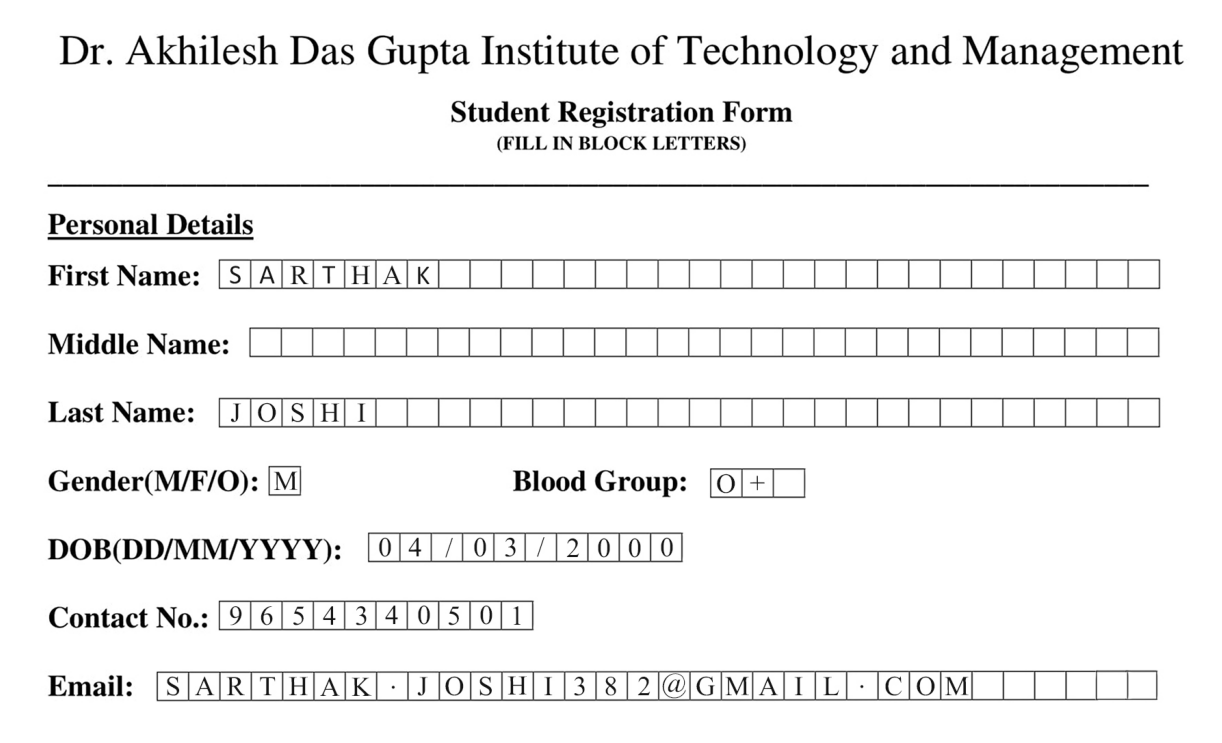

In [8]:
form = cv2.imread('form.jpg')
plt.figure(figsize=(5,5),dpi=300)
plt.axis('off')
plt.imshow(form[:1000,:]);
print(dataExtractor(form))

                Id                       Value
0     First Name:                      5AMARIH
1    Middle Name:                             
2      Last Name:                     GHULYAN1
3         Gender:                            M
4    Blood Group:                           At
5  Date of Birth:                   0IL02L2000
6     Contact No:                   9G5434050I
7          Email:   SAMARIHUGHULYANIQGMAILUC0M


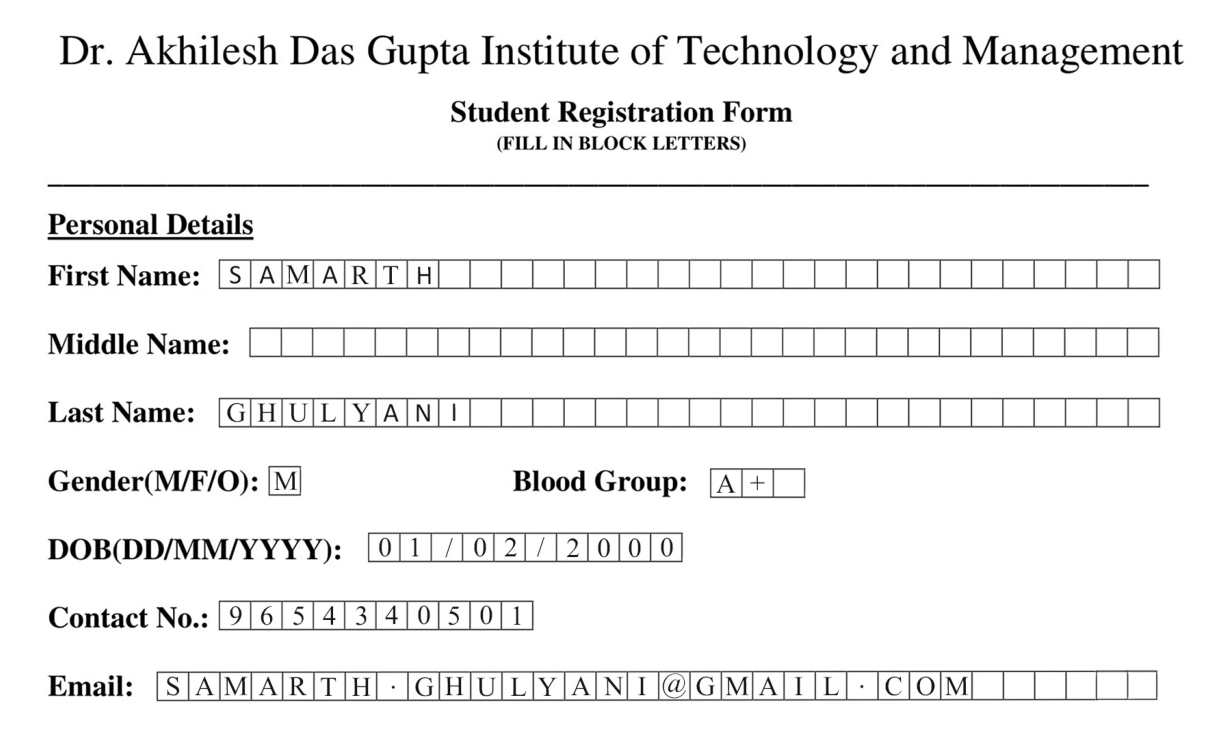

In [9]:
form = cv2.imread('form2.jpg')
plt.figure(figsize=(5,5),dpi=300)
plt.axis('off')
plt.imshow(form[:1000,:]);
print(dataExtractor(form))

                Id                       Value
0     First Name:                        ANK1I
1    Middle Name:                             
2      Last Name:                      ALHAWAT
3         Gender:                            M
4    Blood Group:                           Bt
5  Date of Birth:                   I5L02L2000
6     Contact No:                   7G84G4030I
7          Email:   ANKIIALHAWAII502QGMAILUC0M


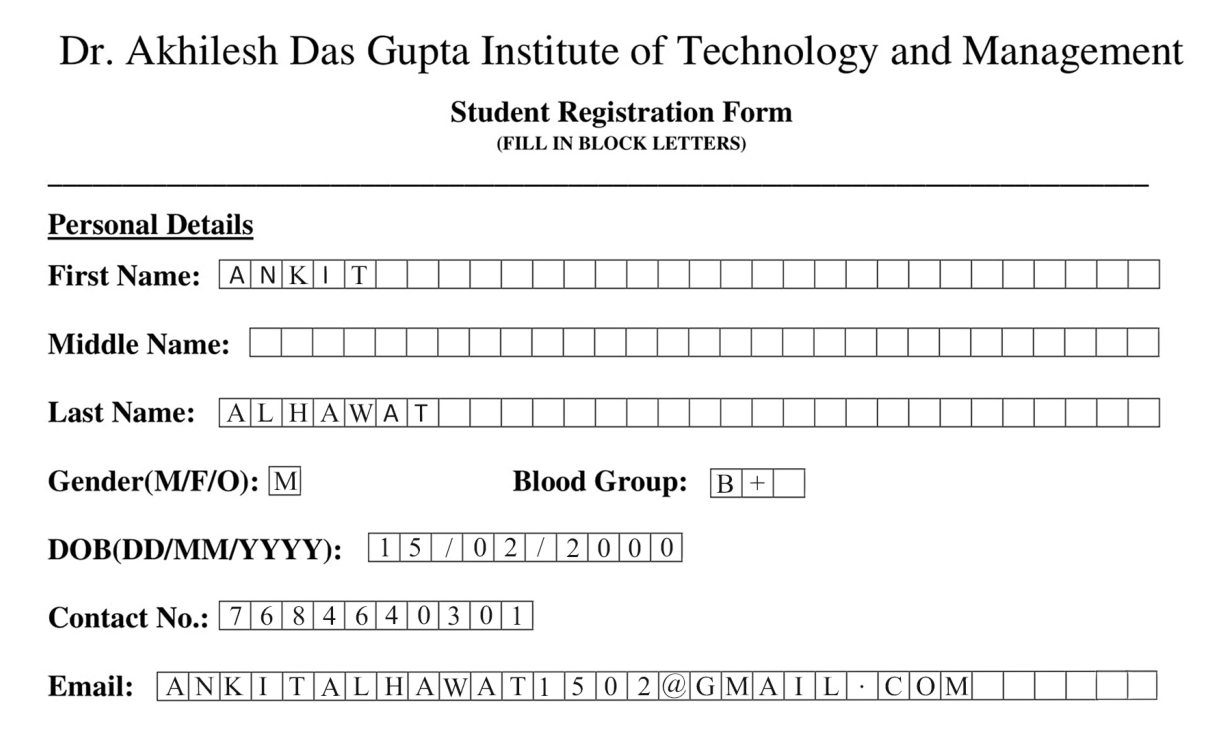

In [10]:
form = cv2.imread('form3.jpg')
plt.figure(figsize=(5,5),dpi=300)
plt.axis('off')
plt.imshow(form[:1000,:]);
print(dataExtractor(form))